# A quoi sert ce notebook ?

- pré-traitement des données textuelles ("description")
- vectorisation
- regression logistique à partir de l'unique variable "description"
- ajout de nouvelles variables binaires

In [1]:
#Import des librairies
import pandas as pd
import numpy as np
import unicodedata
import unidecode
import matplotlib.pyplot as plt
import nltk.stem
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from stop_words import get_stop_words

## Traitement des données

In [2]:
#Lecture des données
df = pd.read_csv("./../data/offers_with_10k_each_contracts.csv")
df.head()

,offer_id,title,description,contract_id,recruiter_id,department_id,industry_id,location,latitude,longitude,created_at
0,620861,Développeur(euse) Android expérimenté(e),LE POSTE\r\nNous mettons aujourd’hui en place ...,1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:37:48.322823
1,620862,Ingénieur QA Mobile,LE POSTE\r\nEn tant qu’Ingénieur Qualité Mobil...,1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:45:00.950319
2,330503,Vérificateur Documents Techniques Aéronautique...,Technicien Vérificateur Documents Techniques A...,1,NaN,108.0,15.0,Donauwörth,48.735699,10.791800,2015-03-26 04:16:35.620706
3,623978,Chef de Produit Mobile,L’EQUIPE\r\nL’équipe Produit & Innovation poss...,1,17524.0,115.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-07-18 14:04:00.652073
4,391895,Ordonnanceur H/F,"Entreprise :\n\nOPTIMA IP, cabinet de recrutem...",1,NaN,117.0,20.0,"Sucy-en-Brie, France",48.770802,2.538860,2015-05-22 10:38:42.117161


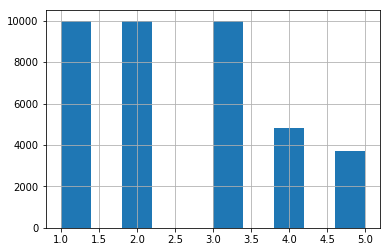

In [122]:
#Répartition des types de contrats
df.contract_id.hist()

In [3]:
#Suppression des échantillons dont la variable contrat est nulle
df = df[df.contract_id.notnull()]          #inutile mais au cas où

In [4]:
#Texte en minuscule et suppression des \n et \r
df['description'] = df['description'].str.lower()
df['title'] = df['title'].str.lower()

df.description = df.description.replace('\r', ' ', regex=True).replace('\n', ' ', regex=True).replace('\t',' ', regex=True)

In [5]:
# Dans la variable 'description'
#Remplacement des valeurs NA par ""

df['description'] = [BeautifulSoup(text, "html.parser").get_text() for text in df['description'].fillna("")]
df['title'] = [BeautifulSoup(text, "html.parser").get_text() for text in df['title'].fillna("")]

In [6]:
df.head()

,offer_id,title,description,contract_id,recruiter_id,department_id,industry_id,location,latitude,longitude,created_at
0,620861,développeur(euse) android expérimenté(e),le poste nous mettons aujourd’hui en place un...,1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:37:48.322823
1,620862,ingénieur qa mobile,"le poste en tant qu’ingénieur qualité mobile,...",1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:45:00.950319
2,330503,vérificateur documents techniques aéronautique...,technicien vérificateur documents techniques a...,1,NaN,108.0,15.0,Donauwörth,48.735699,10.791800,2015-03-26 04:16:35.620706
3,623978,chef de produit mobile,l’equipe l’équipe produit & innovation possèd...,1,17524.0,115.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-07-18 14:04:00.652073
4,391895,ordonnanceur h/f,"entreprise : optima ip, cabinet de recrutemen...",1,NaN,117.0,20.0,"Sucy-en-Brie, France",48.770802,2.538860,2015-05-22 10:38:42.117161


In [7]:
#Définition du préprocessor pour supprimer les digits et transformer le texte en minuscule
def my_preprocessor(text):
    return unidecode.unidecode(''.join([letter for letter in text if not letter.isdigit()]).strip().lower())

In [8]:
#Vectorisation

#stop words fr dans stop_words
stop_wordsFR = get_stop_words('french')
stop_wordsFR.extend(['ca', 'debut', 'etaient', 'etais', 'etait', 'etant', 'etat', 'ete', 'etes', 
                     'etiez', 'etions', 'etre', 'eumes', 'eutes', 'fumes', 'futes', 'meme', 
                     'nomme', 'nommee', 'nommes', 'tres'])

vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    analyzer="word",
    binary=False,
    max_features=5000,
    stop_words = stop_wordsFR,
preprocessor=my_preprocessor)


In [9]:
#tfidf fit de cleaned_description

vectorizer.fit(df.description)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 3), norm='l2',
        preprocessor=<function my_preprocessor at 0x00000239692CD378>,
        smooth_idf=True,
        stop_words=['a', 'ai', 'aie', 'aient', 'aies', 'ait', 'alors', 'as', 'au', 'aucun', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'aux', 'avaient', 'avais', 'avait', 'avant', 'avec', 'avez', 'aviez', 'avions', 'avoir', '..., 'etions', 'etre', 'eumes', 'eutes', 'fumes', 'futes', 'meme', 'nomme', 'nommee', 'nommes', 'tres'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [10]:
X = pd.concat([pd.DataFrame(vectorizer.transform(df.description).todense()), 
               pd.DataFrame(vectorizer.transform(df.title).todense())], axis=1 )

In [11]:
X.shape

(38494, 10000)

## Regression Logistique

Feature : 'description'

In [12]:
#Séparation du jeu de données en base d'apprentissage et base de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df.contract_id, test_size=0.30)

In [13]:
from sklearn.linear_model import LogisticRegression
#Instance d'une régression logistique
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.predict(X_test)

C:\Users\Marine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Marine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([1, 4, 1, ..., 1, 2, 2], dtype=int64)

In [14]:
#Matrice de confusion
print("Matrice de confusion : \n", confusion_matrix(y_test, clf.predict(X_test)))

Matrice de confusion : 
 [[2154  511   44  116  100]
 [ 628 2099   63  140   96]
 [  55   45 2878   38    3]
 [ 496  286  112  430  139]
 [ 441  251   46  144  234]]


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#Score
accuracy_score(clf.predict(X_test), y_test)

0.6749502121395792

In [16]:
print(classification_report(clf.predict(X_test), y_test))

              precision    recall  f1-score   support

           1       0.74      0.57      0.64      3774
           2       0.69      0.66      0.68      3192
           3       0.95      0.92      0.93      3143
           4       0.29      0.50      0.37       868
           5       0.21      0.41      0.28       572

   micro avg       0.67      0.67      0.67     11549
   macro avg       0.58      0.61      0.58     11549
weighted avg       0.72      0.67      0.69     11549



**Testons le Bayes Naive**

In [17]:
#Bayes naive
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=0.1, fit_prior=True)

clf.fit(X_train, y_train)
print('Score = ', clf.score(X_test, y_test))

Score =  0.6082777729673565


In [18]:
import pandas as pd
CC = pd.crosstab(
    y_test,
    clf.predict(X_test),
    rownames=['True'],
    colnames=['Predicted'],
    margins=True)
CC

Predicted,1,2,3,4,5,All
True,,,,,,
1,1761,514,63,226,361,2925
2,624,1883,92,152,275,3026
3,81,127,2710,64,37,3019
4,433,283,163,282,302,1463
5,369,179,60,119,389,1116
All,3268,2986,3088,843,1364,11549


## Ajout des nouvelles variables

In [19]:
#Avant ajout des nouvelles variables
df.head(3)

,offer_id,title,description,contract_id,recruiter_id,department_id,industry_id,location,latitude,longitude,created_at
0,620861,développeur(euse) android expérimenté(e),le poste nous mettons aujourd’hui en place un...,1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:37:48.322823
1,620862,ingénieur qa mobile,"le poste en tant qu’ingénieur qualité mobile,...",1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:45:00.950319
2,330503,vérificateur documents techniques aéronautique...,technicien vérificateur documents techniques a...,1,NaN,108.0,15.0,Donauwörth,48.735699,10.791800,2015-03-26 04:16:35.620706


In [20]:
#Ajout des nouvelles variables
df['contains_cdi'] = df[['description', 'title']].apply(lambda x: 'cdi' in " ".join(x), axis=1).astype(int)
df['contains_cdd'] = df[['description', 'title']].apply(lambda x: 'cdd' in " ".join(x), axis=1).astype(int)
df['contains_stage'] = df[['description', 'title']].apply(lambda x: 'stage' in " ".join(x), axis=1).astype(int)
df['contains_alternance'] = df[['description', 'title']].apply(lambda x: 'alternance' in " ".join(x), axis=1).astype(int)
df['contains_apprenti'] = df[['description', 'title']].apply(lambda x: 'apprenti' in " ".join(x), axis=1).astype(int)
df['contains_vie'] = df[['description', 'title']].apply(lambda x: 'vie' in " ".join(x), axis=1).astype(int)

In [21]:
df.contains_cdi.value_counts()

0    33377
1     5117
Name: contains_cdi, dtype: int64

In [22]:
df

,offer_id,title,description,contract_id,recruiter_id,department_id,industry_id,location,latitude,longitude,created_at,contains_cdi,contains_cdd,contains_stage,contains_alternance,contains_apprenti,contains_vie
0,620861,développeur(euse) android expérimenté(e),le poste nous mettons aujourd’hui en place un...,1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:37:48.322823,0,0,0,0,0,0
1,620862,ingénieur qa mobile,"le poste en tant qu’ingénieur qualité mobile,...",1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:45:00.950319,0,0,0,0,0,0
2,330503,vérificateur documents techniques aéronautique...,technicien vérificateur documents techniques a...,1,NaN,108.0,15.0,Donauwörth,48.735699,10.791800,2015-03-26 04:16:35.620706,0,0,0,0,0,0
3,623978,chef de produit mobile,l’equipe l’équipe produit & innovation possèd...,1,17524.0,115.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-07-18 14:04:00.652073,0,0,0,0,0,0
4,391895,ordonnanceur h/f,"entreprise : optima ip, cabinet de recrutemen...",1,NaN,117.0,20.0,"Sucy-en-Brie, France",48.770802,2.538860,2015-05-22 10:38:42.117161,0,0,0,0,0,0
5,626090,consultant stratégie digitale,vous êtes jeune diplômé(e) d’une grande école ...,1,17549.0,119.0,9.0,"Paris, France",48.856614,2.352222,2017-08-28 08:01:28.911562,0,0,0,0,1,0
6,612987,ingénieur études et développement c# h/f,dans le cadre des projets de développement de ...,1,17561.0,101.0,15.0,"Grenoble, France",45.188529,5.724524,2017-01-10 13:37:17.537197,0,0,0,0,0,0
7,358977,responsable bureau d'études câblage electrique...,entreprise :novajob se veut être le précurseur...,1,NaN,117.0,9.0,"LANGUEDOC ROUSSILL, France",43.593406,3.227784,2015-04-16 08:26:52.143544,0,0,0,0,0,0
8,694642,responsable ingénierie qos,"en 2017, bouygues telecom connait une très for...",1,16826.0,107.0,24.0,13 AVENUE DU MARECHAL JUIN 92360 MEUDON,48.786771,2.220587,2018-08-23 09:38:51.919709,0,0,0,0,0,0
9,565156,sales representative,,1,12374.0,103.0,9.0,"1343 East Gun Hill Road, Bronx, NY, United States",40.870953,-73.846569,2016-04-07 13:04:23.503985,0,0,0,0,0,0


In [23]:
print(df.iloc[30017])

offer_id                                                          680192
title                             apprenti(e) assistant(e) administratif
description            fonctions    • accueillir une clientèle  • cla...
contract_id                                                            4
recruiter_id                                                       24186
department_id                                                        123
industry_id                                                           12
location                                             Montpellier, France
latitude                                                         43.6108
longitude                                                        3.87672
created_at                                    2018-07-03 13:33:17.110475
contains_cdi                                                           0
contains_cdd                                                           0
contains_stage                                     

**Problème : offres mal classées**

In [24]:
text_feature = X
numeric_features = df[['contains_cdi', 'contains_cdd', 'contains_stage', 
                      'contains_alternance', 'contains_apprenti', 'contains_vie']]

In [25]:
numeric_features.shape, X.shape

((38494, 6), (38494, 10000))

In [27]:
X_final = pd.concat([numeric_features, text_feature], axis=1 )

In [28]:
X_final.shape

(38494, 10006)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_final, df.contract_id, test_size=0.30)

In [31]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.predict(X_test)

C:\Users\Marine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Marine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([3, 1, 1, ..., 3, 3, 1], dtype=int64)

In [32]:
print("Matrice de confusion : \n", confusion_matrix(y_test, clf.predict(X_test)))

Matrice de confusion : 
 [[2270  461   57  135   89]
 [ 640 2087   61  160   73]
 [  63   39 2801   46    8]
 [ 494  276  123  462  116]
 [ 443  218   53  158  216]]


In [33]:
accuracy_score(clf.predict(X_test), y_test)

0.6785003030565417

In [34]:
print(classification_report(clf.predict(X_test), y_test))

              precision    recall  f1-score   support

           1       0.75      0.58      0.66      3910
           2       0.69      0.68      0.68      3081
           3       0.95      0.91      0.93      3095
           4       0.31      0.48      0.38       961
           5       0.20      0.43      0.27       502

   micro avg       0.68      0.68      0.68     11549
   macro avg       0.58      0.61      0.58     11549
weighted avg       0.73      0.68      0.70     11549



**TO DO :**
- améliorer le modèle (par ex: compter le nombre de fois que "cdi" est répété


In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.predict(X_test)

array([3, 1, 1, ..., 3, 4, 2], dtype=int64)

In [38]:
print(classification_report(clf.predict(X_test), y_test))

              precision    recall  f1-score   support

           1       0.57      0.56      0.56      3032
           2       0.62      0.60      0.61      3098
           3       0.89      0.90      0.90      2922
           4       0.36      0.36      0.36      1452
           5       0.27      0.28      0.27      1045

   micro avg       0.61      0.61      0.61     11549
   macro avg       0.54      0.54      0.54     11549
weighted avg       0.61      0.61      0.61     11549



In [41]:
df["prediction"] = clf.predict(X_final)

In [43]:
df[df.prediction!=df.contract_id][["title", "description", "prediction", "contract_id"]].head()

,title,description,prediction,contract_id
5,consultant stratégie digitale,vous êtes jeune diplômé(e) d’une grande école ...,4,1
11,un responsable assurance qualite production h/f,randstad vous ouvre toutes les portes de l'emp...,2,1
21,stage ingénieur études et développement bi h/f,"fort de 4000 collaborateurs en europe, sogeti ...",5,1
40,développeur solution mobilité android h/f,avec près de 3000 collaborateurs en france et ...,5,1
55,developpeur as400/ adelia,description du poste : description du poste :...,2,1


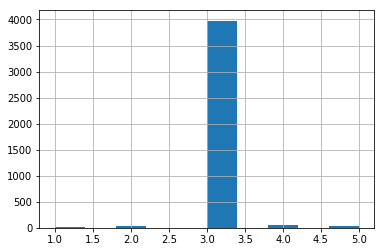

In [49]:
df[df.title.str.contains("stage") ].contract_id.hist()

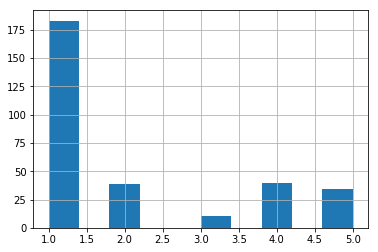

In [50]:
df[df.title.str.contains("cdi") ].contract_id.hist()

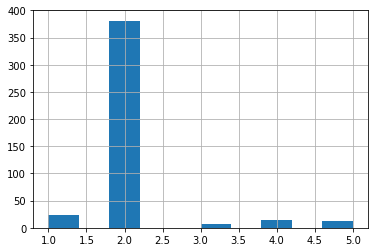

In [51]:
df[df.title.str.contains("cdd") ].contract_id.hist()

**BIG PROBLEME**
 Données mal classées à la base donc score qui ne décolle pas et ne veut rien dire.
 
Solution : on biaise les données. C'est-à-dire qu'on filtre les données que l'on va garder : on supprime les données mal classées qui contiennent dans leur titre ou leur description le type du contrat.

Exemple : le titre de l'offre 6547 contient le mot "stage" mais son contract_id est 1 (cdi) --> poubelle  